# Financial Analytics - Santander Customer Satisfaction Kaggle assignment
### Group E | MBD'18 term 3 | 

In [ ]:
#standard libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
import numpy as np
import seaborn as sns
import random

from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

# Deep Learning
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, BatchNormalization, Input, Concatenate, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras import layers

# Cloud deep learning
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras.utils import multi_gpu_model


First for reproducibility we will set a global seed for this whole notebook.

In [2]:
np.random.seed(8888)
random.seed(8888)

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
print(train.shape)
print(test.shape)

(76020, 371)
(75818, 370)


# 1. Data Preperation
## 1.1 Inspect train and test

Let's see if the ID column is full of uniques. If this is the case we can delete them.

In [5]:
print(len(np.unique(train['ID'])) == len(train))
print(len(np.unique(test['ID'])) == len(test))

True
True


They are unique and thus safe to delete.

In [6]:
train.drop(['ID'], inplace=True, axis=1)
test.drop(['ID'], inplace=True, axis=1)

## 1.2 no information columns

It seems that a lot of columns don't have a lot of information or are duplicates. Let's write a function to check whether a column has only one unique value. First though we'll combine the train and test set to make sure they stay congruent.

In [7]:
ytrain = train.TARGET
train.drop(['TARGET'], inplace = True, axis = 1)

In [8]:
features = pd.concat([train, test]).reset_index(drop=True)
features.shape

(151838, 369)

In [9]:
def unique_values(df, column):
    if len(np.unique(df[column])) == 1:
        df.drop([column], inplace=True, axis=1)

In [10]:
for i in features.columns:
    unique_values(features, i)

In [11]:
features.shape

(151838, 335)

## 1.3 Duplicate columns
Let's also write a function to clean all the duplicate columns from the dataset.

In [12]:
duplicates =[]
for i in range(len(features.columns)-1):
    values = features[features.columns[i]].values
    for j in range(i+1, len(features.columns)):
        if np.array_equal(values, features[features.columns[j]].values):
            duplicates.append(features.columns[j])

In [13]:
features.drop(duplicates, inplace=True, axis=1)

In [14]:
features.shape

(151838, 308)

Looks like we managed to bring down the dataset to a more manageable size. 

## 1.4 Row duplicates

Let's first check how noisy the dataset is by comparing individual rows to eachother. We only do this to the training set because we want to see if they are true duplicates or if they still differ in the target.

In [15]:
train2 = features.loc[:len(ytrain),:]

#create a list of columns to use for a groupby argument
cols = features.columns.tolist()

In [16]:
#Create an index based on a groupby to make sure I know the locations of the original row to compare too.
train2['index_original'] = train2.groupby(cols).imp_ent_var16_ult1.transform('idxmin')

C:\Users\Laurens\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
train2.index_original.tail()

76016    76016.0
76017    76017.0
76018    76018.0
76019     1132.0
76020    76020.0
Name: index_original, dtype: float64

In [18]:
#create a dataframe of all duplicate rows with the original row
duplicated_rows = train2[train2.duplicated(subset=cols, keep=False)]

In [19]:
duplicated_rows.shape

(5900, 309)

Looks like there are almost 6k duplicate rows. This is extremely suspicious as we have more than 300 columns and thus extremely unlikely that these are accidents. Let's see what the Target says about these customers.

In [20]:
duplicated_rows['target'] = ytrain

C:\Users\Laurens\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
noise = duplicated_rows.groupby(['index_original','target']).target.count()

We can clearly see there are rows with inconsistent target values.

Now let's extract from these indices the indices that do not have the same target value for each. This is because this is clearly noisy and will confuse every algorithm we throw at it.

In [22]:
noise2 = []
counter = 0
for i in range(len(noise)):
    counter += 1
    if counter == len(noise):
        break
    if noise.index[i][0] == noise.index[i+1][0]:
        noise2.append(noise.index[i][0])

In [23]:
noise2 = [int(_) for _ in noise2]
len(noise2)

133

We'll extract these rows and not use them for training. After our models are trained we can try to eek out a slightly higher performance by using an ensemble to 'vote' on the correct label for these duplicated rows. And then we can reuse them for training.

In [24]:
noisey_rows = features.iloc[noise2,:]
features = features.drop(features.index[noise2])
ytrain = ytrain.drop(ytrain.index[noise2])

In [25]:
print(features.shape)
print(ytrain.shape)

(151705, 308)
(75887,)


In [26]:
features.reset_index(inplace=True, drop = True)


Now let's do a deep dive in what the features mean and what the dataset looks like. Afterwards we'll run a simple model to check feature importance.

# 2. Feature exploration
## 2.1 Target

In [27]:
ytrain.value_counts()

0    72909
1     2978
Name: TARGET, dtype: int64

The dataset is extremely unbalanced with ~95% 0 (which we assume to be HAPPY customers) and ~5% 1 (which we assume to be UNHAPPY customers). We have to keep this in mind because most models don't deal well with such an unbalanced dataset. Perhaps we'll work with SMOTE or newer state of the art methods to build new negative classes. We will also try under and over sampling. One type of under-sampling we will work with is balanced bagging, where we take bootstrap samples of the whole set (while undersampling the '0' class) and train a learner on each bootstrap. After which we will use a hard or soft voting ensemble to average them out. 

## 2.2 Features

The description of features is non-existent which reduces opportunity for feature engineering. We went through all features to check for interesting values or incorrect value imputation. Below is **only** the features that were interesting for some reason.

Besides that, we ran a quick and dirty model to figure out what features seemed to be important and check them in more detail too.

Finally, first we checked missing values.

In [28]:
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


Not a single missing value but perhaps imputation of values that were clearly missing could be improved.

In [29]:
pd.options.display.max_columns = 350
features.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var34_0,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var44_0,ind_var44,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var34_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var13_medio_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_

In [30]:
features.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var34_0,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var44_0,ind_var44,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var34_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var13_medio_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_

A few features immediately stand out.

- var3 (very low minimum)
- var38 (naming convention and generally high values)

Let's take a closer look at these.

### Var3

C:\Users\Laurens\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


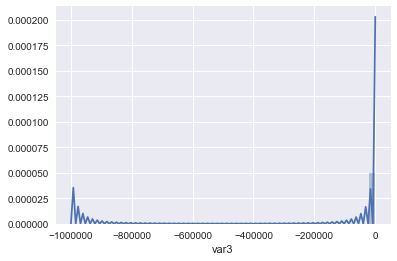

In [32]:
sns.distplot(features.var3)

In [33]:
features.var3.value_counts().head(n=10)

 2         147994
 8            254
-999999       236
 9            218
 3            215
 13           205
 1            204
 7            170
 12           168
 10           157
Name: var3, dtype: int64

Looks like Santander imputed missing values with -999999. Let's replace all of those for the most common value instead).

In [34]:
features.loc[features.var3 == -999999, 'var3'] = 2

### var38

C:\Users\Laurens\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


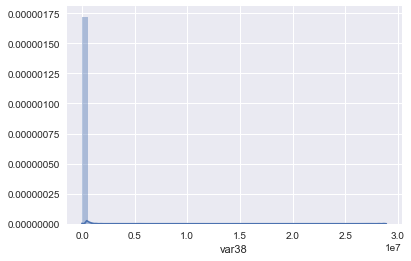

In [35]:
sns.distplot(features.var38)

In [36]:
features.var38.value_counts().head(n=20)

117310.979016    29541
451931.220000       32
288997.440000       21
128318.520000       19
463625.160000       17
104563.800000       17
97639.560000        14
168733.620000       13
329603.970000       13
104644.410000       13
236690.340000       12
100466.730000       12
227397.720000       11
125722.440000       10
135522.150000       10
83174.280000        10
67088.310000        10
163432.470000        9
70813.800000         9
152784.210000        9
Name: var38, dtype: int64

In [37]:
mode = features.var38.mode()
print(mode[0])

117310.979016494


In [38]:
features.loc[features['var38'] != mode[0], 'var38'].mean()

117310.88677269824

It looks like the average without the most common value is quite close to the most common value. So either this was a missing value that has been mean imputed with an old mean(?) or it has been mode imputed and this is a transformed variable. Let's check out the log distribution without the mode.

C:\Users\Laurens\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


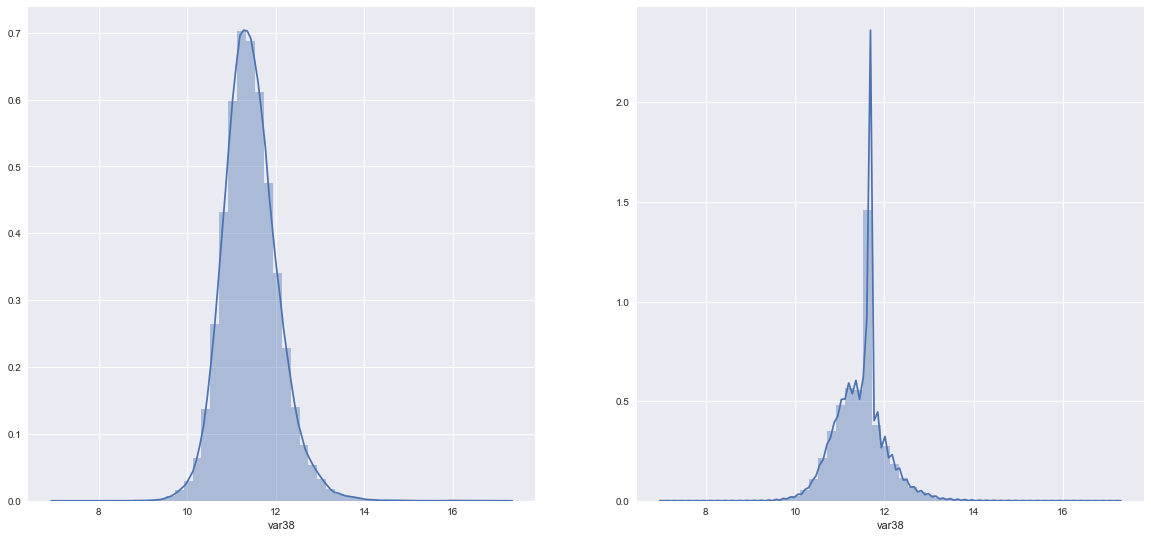

In [39]:
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sns.distplot(np.log(features.loc[features['var38'] != mode[0], 'var38']))

plt.subplot(2,2,2)
sns.distplot(np.log(features.var38))

This calls for some feature engineering. We'll create a variable that denotes whether the row has the most common value for var38 (binary) and log transform this and other variables.

In [40]:
features['var38_mode_bin'] = [1 if features.loc[x,'var38'] == 117310.979016494 else 0 for x, y in enumerate(features.var38)]

We'll also create replace that value with -1 in the original so that it's clearer to the algorithm that it's a missing value.

In [160]:
features['var38'].replace(117310.979016494, -1.0, inplace=True)

## 2.3 Factorization

Some features are coded as numerical but should actually be categorical. Let's write a function to detect these. We decided on the relatively arbitrary rule of more than 2 uniques (because these are already dummies of categoricals) and secondly them being integers. The assumption is that all the float variables are true numericals.

In [42]:
def detect_cats(df, column):
    if features[column].dtype != 'float64' and len(df[column].value_counts()) > 2:
        return True
    else:
        pass

In [43]:
cats = []
for i in features.columns:
    if detect_cats(features, i) != None:
        cats.append(i)

Let's now push these columns to object type instead of integer. Obviously our algorithms won't be able to use categorical variables so we will deal with them in various ways later. We'll experiment with standard one-hot encoding but also with entity embedding of the categoricals.

In [44]:
features[cats] = features[cats].astype('str')

In [45]:
features.dtypes.value_counts()

object     115
float64    114
int64       80
dtype: int64

## 2.4 Outlier detection

Since we are talking banking information its very likely that some accounts have very big values which will hurt our ability to generalize. We'll apply a two step process to removing outliers. 

1. to optimize generalization from the train set we'll create bounding limits based on minimums and maximums of the train set for the testset
2. We'll apply Local Outlier Factor, a novel algorithm to detect outliers in the data.

We'll do the first here (before normalizing our data) and the other one after we finalize feature creation.

### 2.4.1 Limit the test set

The idea is pretty simple; to improve generalizability we want to make sure the maximums and minimums of the test set aren't higher than they are in the train set.

In [61]:
def set_lims(features):
    temp_train = features.iloc[:len(ytrain),:]
    temp_test = features.iloc[len(ytrain):,:]
    for i in temp_test.columns:
        lower_lim = min(temp_train.loc[:,i])
        temp_test.loc[temp_test.loc[:,i] < lower_lim, i] = lower_lim
        
        higher_lim = max(temp_train.loc[:,i])
        temp_test.loc[temp_test.loc[:,i] > higher_lim, i] = higher_lim
        
    features = pd.concat([temp_train, temp_test], axis = 0)
    
    return features

In [68]:
features = set_lims(features)

C:\Users\Laurens\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## 2.5 Feature transformations

Now that we excluded all the categoricals let's get all our truly numerical variables and see if they will require some standardization or transformation.

In [69]:
numericals = features.select_dtypes(exclude = ['object', 'int64'])

Let's check how our variables are distributed by analyzing the skewness.

In [70]:
from scipy.stats import skew

skew_features = numericals.apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews.head(n=10)

,skew
saldo_medio_var29_hace3,389.489409
imp_reemb_var17_hace3,389.489409
saldo_var1,380.131329
saldo_medio_var17_hace3,379.987750
imp_aport_var17_hace3,379.759108
imp_amort_var18_ult1,367.875284
saldo_medio_var17_hace2,366.148801
saldo_var17,352.348839
saldo_medio_var17_ult3,346.789513
saldo_medio_var17_ult1,337.684715


Let's plot a few.

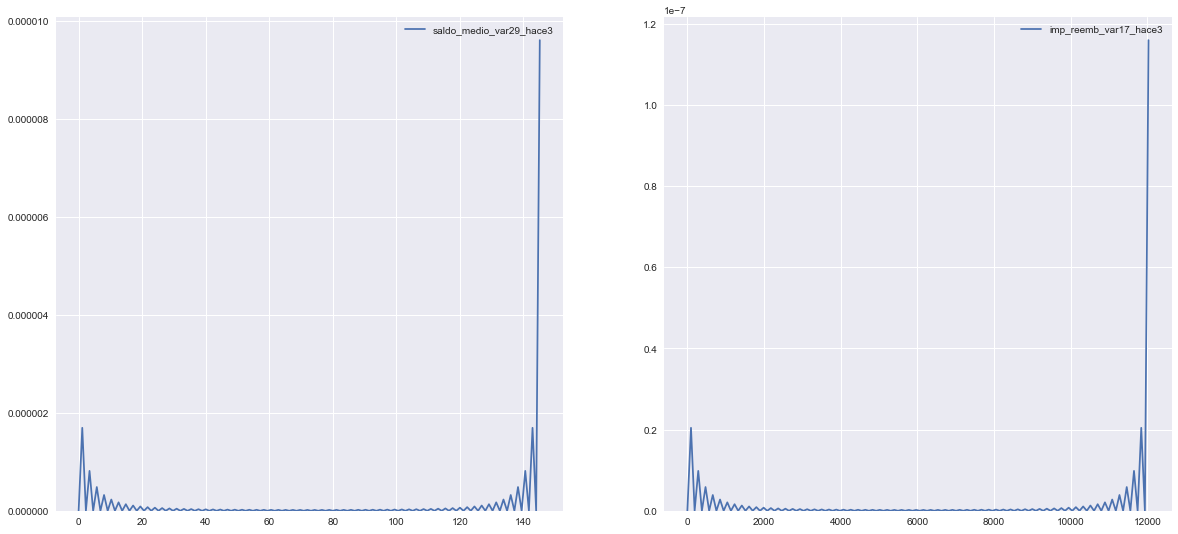

In [71]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
sns.kdeplot(features.saldo_medio_var29_hace3)

plt.subplot(2,2,2)
sns.kdeplot(features.imp_reemb_var17_hace3)

Clearly the numerical features are heavliy skewed. There's a few techniques to solve this; we could apply a log transformation, or a boxcox transformation. However, the data has some negative values so we would have to add a constant value to all the data to achieve this. A more novel and advanced technique is called GaussRankScaler, proposed by Michael Jahrer the winner of the Porto Seguro Safe driver kaggle competition who shared his result afterwards (https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629#250927) mentioned that this type of scaling works especially well for neural networks which is something we want to try extensively on this dataset. Also in our own experimentation it showed extreme success on normalizing the data.

The scaler works relatively simple; First you apply a linear space vector creator over the ordered values in each variable, then you apply the inverse of the scipy erf function. This function is just a Gaussian Error function and squishes the ordered data into a normal distribution between 0 and 1.

In [72]:
from scipy.special import erfinv

class GaussRankScaler():

    def __init__( self ):
        self.epsilon = 0.001
        self.lower = -1 + self.epsilon
        self.upper =  1 - self.epsilon
        self.range = self.upper - self.lower

    def fit_transform( self, X ):
    
        i = np.argsort( X, axis = 0 )
        j = np.argsort( i, axis = 0 )

        assert ( j.min() == 0 ).all()
        assert ( j.max() == len( j ) - 1 ).all()
        
        j_range = len( j ) - 1
        self.divider = j_range / self.range
        
        transformed = j / self.divider
        transformed = transformed - self.upper
        transformed = erfinv( transformed )
        
        return transformed

In [73]:
scaler = GaussRankScaler()
test = scaler.fit_transform(numericals)

In [74]:
from scipy.stats import skew

skew_features = test.apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews.head(n=10)

,skew
imp_reemb_var17_ult1,1.895613e-16
saldo_var40,-1.073192e-16
imp_reemb_var13_ult1,-1.164872e-16
delta_imp_venta_var44_1y3,-1.677199e-16
saldo_medio_var44_hace3,-1.841683e-16
imp_aport_var33_hace3,-2.060097e-16
imp_op_var40_comer_ult1,-2.327047e-16
imp_amort_var18_ult1,-2.383672e-16
saldo_medio_var33_ult1,-2.397155e-16
imp_aport_var17_ult1,-2.405244e-16


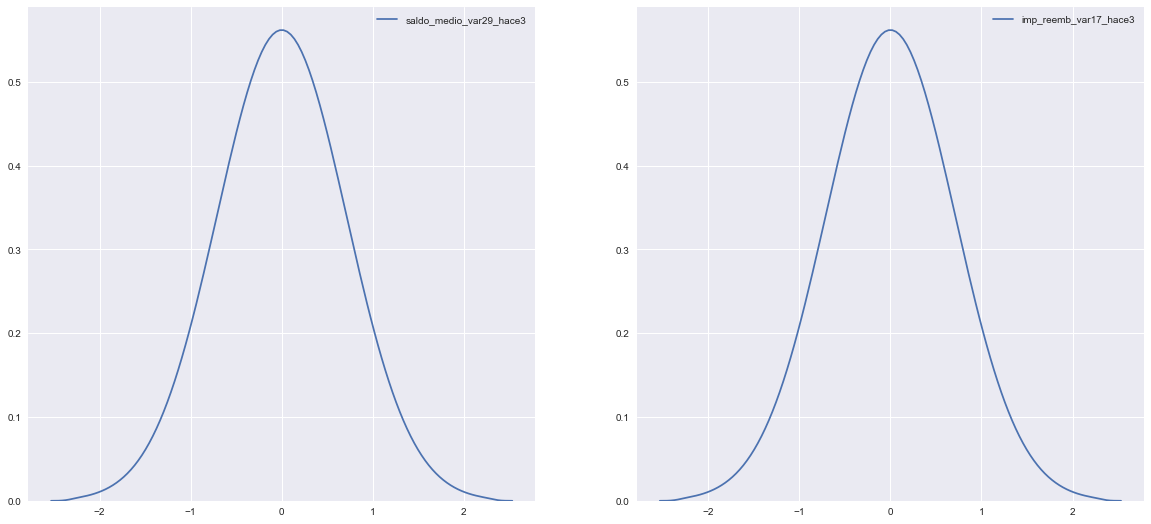

In [75]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
sns.kdeplot(test.saldo_medio_var29_hace3)

plt.subplot(2,2,2)
sns.kdeplot(test.imp_reemb_var17_hace3)

This RankGauss transformation helped immensely. 

In [76]:
features[test.columns] = test

In [77]:
features.shape

(151705, 309)

In [78]:
features.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var31_0,ind_var31,ind_var32_cte,ind_var32_0,ind_var33_0,ind_var33,ind_var34_0,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var40,ind_var41_0,ind_var44_0,ind_var44,num_var1_0,num_var1,num_var4,num_var5_0,num_var5,num_var6_0,num_var6,num_var8_0,num_var8,num_var12_0,num_var12,num_var13_0,num_var13_corto_0,num_var13_corto,num_var13_largo_0,num_var13_largo,num_var13_medio_0,num_var13_medio,num_var13,num_var14_0,num_var14,num_var17_0,num_var17,num_var18_0,num_var20_0,num_var20,num_var24_0,num_var24,num_var26_0,num_var25_0,num_op_var40_hace2,num_op_var40_hace3,num_op_var40_ult1,num_op_var40_ult3,num_op_var41_hace2,num_op_var41_hace3,num_op_var41_ult1,num_op_var41_ult3,num_op_var39_hace2,num_op_var39_hace3,num_op_var39_ult1,num_op_var39_ult3,num_var30_0,num_var30,num_var31_0,num_var31,num_var32_0,num_var33_0,num_var33,num_var34_0,num_var35,num_var37_med_ult2,num_var37_0,num_var39_0,num_var40_0,num_var40,num_var41_0,num_var42_0,num_var42,num_var44_0,num_var44,saldo_var1,saldo_var5,saldo_var6,saldo_var8,saldo_var12,saldo_var13_corto,saldo_var13_largo,saldo_var13_medio,saldo_var13,saldo_var14,saldo_var17,saldo_var18,saldo_var20,saldo_var24,saldo_var26,saldo_var25,saldo_var30,saldo_var31,saldo_var32,saldo_var33,saldo_var34,saldo_var37,saldo_var40,saldo_var42,saldo_var44,var36,delta_imp_amort_var18_1y3,delta_imp_amort_var34_1y3,delta_imp_aport_var13_1y3,delta_imp_aport_var17_1y3,delta_imp_aport_var33_1y3,delta_imp_compra_var44_1y3,delta_imp_reemb_var13_1y3,delta_imp_reemb_var17_1y3,delta_imp_reemb_var33_1y3,delta_imp_trasp_var17_in_1y3,delta_imp_trasp_var17_out_1y3,delta_imp_trasp_var33_in_1y3,delta_imp_trasp_var33_out_1y3,delta_imp_venta_var44_1y3,delta_num_aport_var13_1y3,delta_num_aport_var17_1y3,delta_num_aport_var33_1y3,delta_num_compra_var44_1y3,delta_num_venta_var44_1y3,imp_amort_var18_ult1,imp_amort_var34_ult1,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_aport_var17_hace3,imp_aport_var17_ult1,imp_aport_var33_hace3,imp_aport_var33_ult1,imp_var7_emit_ult1,imp_var7_recib_ult1,imp_compra_var44_hace3,imp_compra_var44_ult1,imp_reemb_var13_ult1,imp_reemb_var17_hace3,imp_reemb_var17_ult1,imp_reemb_var33_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1,imp_trasp_var17_in_hace3,imp_trasp_var17_in_ult1,imp_trasp_var17_out_ult1,imp_trasp_var33_in_hace3,imp_trasp_var33_in_ult1,imp_trasp_var33_out_ult1,imp_venta_var44_hace3,imp_venta_var44_ult1,ind_var7_emit_ult1,ind_var7_recib_ult1,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var21,num_aport_var13_hace3,num_aport_var13_ult1,num_aport_var17_hace3,num_aport_var17_ult1,num_aport_var33_hace3,num_aport_var33_ult1,num_var7_emit_ult1,num_var7_recib_ult1,num_compra_var44_hace3,num_compra_var44_ult1,num_ent_var16_ult1,num_var22_hace2,num_var22_hace3,num_var22_ult1,num_var22_ult3,num_med_var22_ult3,num_med_var45_ult3,num_meses_var5_ult3,num_meses_var8_ult3,num_meses_var12_ult3,num_meses_var13_corto_ult3,num_meses_var13_largo_ult3,num_meses_var13_medio_ult3,num_meses_var17_ult3,num_meses_var29_ult3,num_meses_var33_ult3,num_meses_var39_vig_ult3,num_meses_var44_ult3,num_op_var39_comer_ult1,num_op_var39_comer_ult3,num_op_var40_comer_ult1,num_op_var40_comer_ult3,num_

This finalizes our preprocessing and cleaning for now. We'll write out our current feature set to a csv so that we dont have to redo these steps everytime we want to run something on our GPU instance in the google cloud.

# checkpoint 1 - preprocessing

In [79]:
features.to_csv("preprocessed_features.csv", index=False)

In [80]:
ytrain.to_csv('ytrain.csv', index = False)

read back in:

In [47]:
features = pd.read_csv("preprocessed_features.csv")
print(features.shape)

(151705, 309)


In [33]:
ytrain = pd.read_csv("ytrain.csv", header = None)
print(ytrain.shape)

(75888, 1)


we have to redo the factorization because of weird import rules from pandas.

In [51]:
def detect_cats(df, column):
    if features[column].dtype != 'float64' and len(df[column].value_counts()) > 2:
        return True
    else:
        pass
    
cats = []
for i in features.columns:
    if detect_cats(features, i) != None:
        cats.append(i)

features[cats] = features[cats].astype('str')

print(features.dtypes.value_counts())

float64    114
object     111
int64       84
dtype: int64


# 3. Feature engineering

## 3.1 Baseline model

Just to see what features spring out as important and to have some baseline accuracy to compare more complex models too we first build two baselines. A simple random forest and a simple feed forward neural network to compare our more complex architectures too. Even though we mentioned wanting to use entity embedding later, for now we'll just use one-hot encoding for our categoricals.

In [104]:
from sklearn.model_selection import train_test_split

dummies = pd.get_dummies(features)
train_features = dummies[:len(ytrain)]
test_features = dummies[len(ytrain):]

X, X_val, y, y_val = train_test_split(train_features, ytrain, test_size = 0.2,
                                     random_state = 42, shuffle = True)

print('X shape:',X.shape)
print('y shape:',y.shape)
print('X_val shape:',X_val.shape)
print('y_val shape:',y_val.shape)

X shape: (60710, 1164)
y shape: (60710, 1)
X_val shape: (15178, 1164)
y_val shape: (15178, 1)


Let's setup our baseline model and scoring functions. It should be noted that we are using stratified cross validation due to the severe inbalance of the target variable.

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.pipeline import make_pipeline

#Build our model method
rf = RandomForestClassifier()

#Build our cross validation method
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#build our model scoring function
def cv_auc(model):
    auc = cross_val_score(model, X, y, 
                               scoring="roc_auc", 
                               cv = kfolds, verbose = 1, n_jobs=3)
    return(auc)


#validation accuracy function
def val_auc(model):
    auc = cross_val_score(model, X_val, y_val,
                         scoring = 'roc_auc',
                         cv=kfolds, verbose = 1, n_jobs=3)
    
    return(auc)

In [42]:
benchmark_model = rf.fit(X=X, y=y)

print("cross validated auc:", cv_auc(benchmark_model).mean())
print("val_auc:", val_auc(benchmark_model).mean())

C:\Users\Laurens\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   42.9s finished


cross validated auc: 0.49914538016755605
val_auc: 0.5048346790954815


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   10.5s finished


We are getting a pretty low score with random forest. This is probably because of the sparsity and due to the fact we haven't done any hyperparameter optimization. 

Even though the score is quite low its useful to figure out what features the model thinks are important. This might give some insight.

In [107]:
baseline_rf_coeffs = pd.DataFrame(list(zip(X.columns, benchmark_model.feature_importances_)), columns=['Predictors', 'Coefficients'])

baseline_rf_coeffs.sort_values(by='Coefficients', ascending=False).head(n=15)

,Predictors,Coefficients
192,var38,0.013424
88,saldo_var30,0.012708
75,saldo_var5,0.011209
156,saldo_medio_var5_ult3,0.009999
8,imp_op_var41_comer_ult1,0.009622
94,saldo_var42,0.009006
14,imp_op_var39_efect_ult3,0.008729
11,imp_op_var41_efect_ult3,0.008668
153,saldo_medio_var5_hace2,0.008650
10,imp_op_var41_efect_ult1,0.008588


The ones that immediately jump out are the 'saldo_var..' variables. They might indicate the amount of money in an account. Perhaps we can do some feature engineering with this, some combination of those might work.

## 3.2 Simple Neural Network baseline

One issue that arises with using neural networks is that often people overcomplicate their architecture too fast. Because of this we create a very simple fully connected feed-forward network just to see what kind of performance we get. Later we can start increasing capacity little by little.

In [43]:
X.shape

(60710, 3133)

In [105]:
from tensorflow import set_random_seed
set_random_seed(15)

input_tensor = Input(shape = (X.shape[1],))
x = Dense(64, activation = 'relu')(input_tensor)
x = Dense(32, activation = 'relu')(x)
x = Dense(16, activation = 'relu')(x)
output_tensor = Dense(1, activation = 'sigmoid')(x)

baseline_nn_model = Model(input_tensor, output_tensor)
baseline_nn_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1164)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                74560     
_________________________________________________________________
dense_30 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_31 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 17        
Total params: 77,185
Trainable params: 77,185
Non-trainable params: 0
_________________________________________________________________


In [106]:
baseline_nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [107]:
epochs = 5
batch_size = 128
baseline_nn_model.fit(X, y,
                      batch_size=batch_size,
                      epochs=epochs,
                     validation_data=(X_val, y_val))

Train on 60710 samples, validate on 15178 samples
Epoch 1/5
60710/60710 [==============================] - 4s 72us/step - loss: 0.1922 - acc: 0.9585 - val_loss: 0.1851 - val_acc: 0.9599
Epoch 2/5
60710/60710 [==============================] - 4s 71us/step - loss: 0.1806 - acc: 0.9603 - val_loss: 0.1842 - val_acc: 0.9599
Epoch 3/5
60710/60710 [==============================] - 4s 71us/step - loss: 0.1785 - acc: 0.9604 - val_loss: 0.1826 - val_acc: 0.9600
Epoch 4/5
60710/60710 [==============================] - 4s 72us/step - loss: 0.1757 - acc: 0.9605 - val_loss: 0.1848 - val_acc: 0.9599
Epoch 5/5
60710/60710 [==============================] - 4s 71us/step - loss: 0.1783 - acc: 0.9604 - val_loss: 0.1740 - val_acc: 0.9605


This very simple neural network already gets a high local validation score. However, the network is cleary overfitting as a quick upload to benchmark on kaggle shows that we achieved 0.80 auc on the leaderboard. Clearly we could do better with optimizing our architecture, our learning rate, our batch size and regularization.

Nowe that we have finished our baselines let's start doing some feature engineering.

## 3.3 Feature Creation

We had a few ideas for feature creation that made sense. The ideas are described below.

1. There are a ton of variables that are 0 for a lot of users. This might indicate they don't use certain products etc. This might be significant so we will add a feature that counts the number of zeros in each row.

2. As already discussed in the var38 discussion above; We want to make a boolean variable if the row has the very common var38 value which is suspected to be a filled null value. - this one we already did above.

3. The high dimensionality and occurance of numericals makes us think that we can get a better represenation of the information space by using dimensionality reduction methods to create new features. We want to try:
    - PCA features 
    - T-SNE features
    - KNN extracted features

4. Since we know so little about the variables we will use a genetic algorithm to try various transformations (log, sqr, exp, minus, plus etc.) but only keep the transformed/combined variables that add value to the model.

5. Above we identified some variables we suspect to be categorical. A novel way to encode these for learners is to embed them in a high-dimensional latent space as a vector. This prevents the model from assuming that order is irrelevant OR relevant by embedding levels of the categorical that are closer to each other in reality -- closer to each other in this latent space. An example would be for a variable 'country': the model would interpret 1 = france and 2 = china and 3 = germany the same way, even though 1 and 3 should be closer together since they are more similar. Entity embedding fixes this by embedding these levels closer together. It's similar to word2vec style embedding in NLP. The idea was first proposed here: https://arxiv.org/pdf/1604.06737.pdf

Let's start building these features.

### 3.3.1 zero count



In [80]:
features['zero_count'] = features.apply(lambda x: np.sum(x==0), axis =1)

### 3.3.2 var38 feature

Already done above.

### 3.3.3 Dimensionality reduction features


Let's build T-SNE features. t-distributed Stochastic Neighbor Embedding is a novel way to reduce dimensionality of a dataset that is both non-linear (unlinke PCA) and non-parametric. Since we have 300+ features the assumption that reducing dimensions linearly is helpful is not a great one. So besides PCA we'll also implement T-SNE features.

In [392]:
from sklearn.manifold import TSNE

tsne_plot_feautures = TSNE(n_components = 2, verbose = 10).fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 151705 samples in 156.511s...
[t-SNE] Computed neighbors for 151705 samples in 4003.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 151705
[t-SNE] Computed conditional probabilities for sample 2000 / 151705
[t-SNE] Computed conditional probabilities for sample 3000 / 151705
[t-SNE] Computed conditional probabilities for sample 4000 / 151705
[t-SNE] Computed conditional probabilities for sample 5000 / 151705
[t-SNE] Computed conditional probabilities for sample 6000 / 151705
[t-SNE] Computed conditional probabilities for sample 7000 / 151705
[t-SNE] Computed conditional probabilities for sample 8000 / 151705
[t-SNE] Computed conditional probabilities for sample 9000 / 151705
[t-SNE] Computed conditional probabilities for sample 10000 / 151705
[t-SNE] Computed conditional probabilities for sample 11000 / 151705
[t-SNE] Computed conditional probabilities for sample 12000 / 151705
[t-SNE] Computed conditional pr

[t-SNE] Computed conditional probabilities for sample 118000 / 151705
[t-SNE] Computed conditional probabilities for sample 119000 / 151705
[t-SNE] Computed conditional probabilities for sample 120000 / 151705
[t-SNE] Computed conditional probabilities for sample 121000 / 151705
[t-SNE] Computed conditional probabilities for sample 122000 / 151705
[t-SNE] Computed conditional probabilities for sample 123000 / 151705
[t-SNE] Computed conditional probabilities for sample 124000 / 151705
[t-SNE] Computed conditional probabilities for sample 125000 / 151705
[t-SNE] Computed conditional probabilities for sample 126000 / 151705
[t-SNE] Computed conditional probabilities for sample 127000 / 151705
[t-SNE] Computed conditional probabilities for sample 128000 / 151705
[t-SNE] Computed conditional probabilities for sample 129000 / 151705
[t-SNE] Computed conditional probabilities for sample 130000 / 151705
[t-SNE] Computed conditional probabilities for sample 131000 / 151705
[t-SNE] Computed con

In [405]:
tsne_features = pd.DataFrame(tsne_plot_feautures, columns = ['tsne_1', 'tsne_2'])

In [400]:
tsne_features.to_csv('tsne_f.csv', index = False)

In [29]:
tsne_features = pd.read_csv("tsne_f.csv")

We again push this to CSV format since it took ~9 hours to build these. Let's also plot these two T-SNE features together with our target variable to see how well it seperated the two.

In [406]:
tsne_yt = pd.concat([tsne_features[:len(ytrain)], ytrain], axis = 1)

In [411]:
tsne_yt.columns = ['tsne_1', 'tsne_2', 'label']

To make the plot more interpretable we'll take a stratified sample for visualization. We'll take a stratified sample to keep an even distribution of 0 and 1 labels.

In [425]:
stratified_sample = tsne_yt.groupby('label').apply(lambda x: x.sample(frac=0.1))

In [428]:
stratified_sample.shape

(7589, 3)

Text(0,0.5,'T-SNE feature 2')

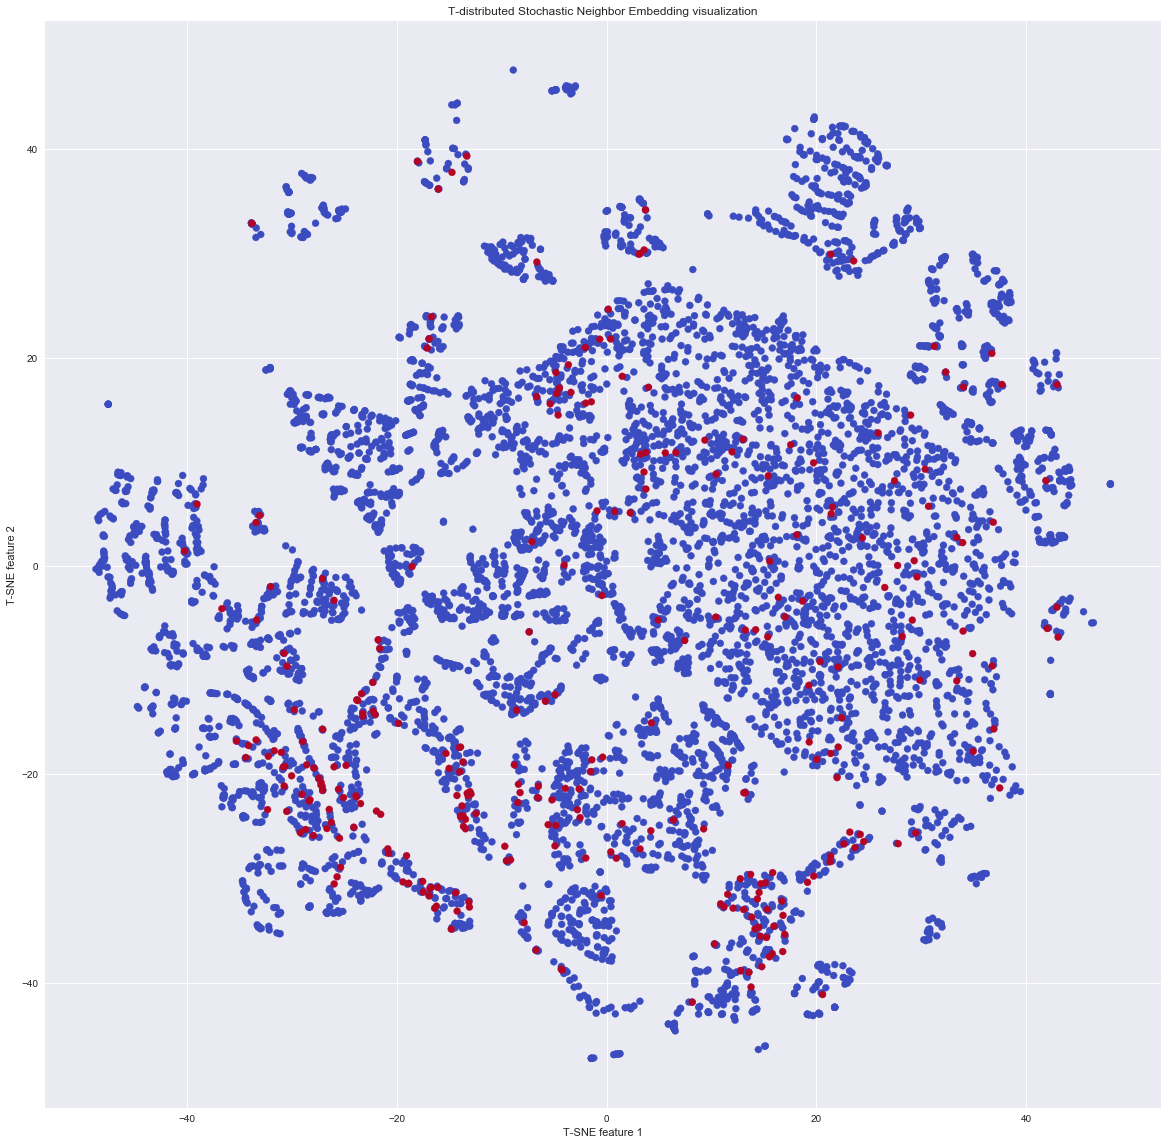

In [434]:
plt.figure(figsize = (20,20))
plt.scatter(stratified_sample['tsne_1'], stratified_sample['tsne_2'], 
            c=stratified_sample['label'], cmap=plt.cm.get_cmap("coolwarm", 2))
plt.title("T-distributed Stochastic Neighbor Embedding visualization")
plt.xlabel("T-SNE feature 1")
plt.ylabel("T-SNE feature 2")

The visualization doesn't completely pull apart the positive and negative satisfaction customers but very much does show concentrated groups of dissatisfied customers. This is the power of T-SNE and this will allow our algorithms to pick out these clusters.

Finally, let's also create K-means clustering features. The basic gist of this is that we cluster the data and add the number of the cluster the row belongs to as a feature.



In [37]:
from sklearn.cluster import KMeans

kmeans_features = pd.DataFrame()
kmeans_features_list = []
for num_clusters in range(2,11):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans_features['cluster_'+str(num_clusters)] = kmeans.fit_predict(features.values)
    kmeans_features_list.append('cluster_'+str(num_clusters))

kmeans_features = kmeans_features.astype('int')

Lets concat them all to the feature set.

In [95]:
features = pd.concat([features, tsne_features, kmeans_features], axis = 1)

### 3.3.4 Genetic algorithm features

Here I'll use genetic programming to combine features into new features and test their fitness to find strong predictors.

I'll be using the sklearn wrapper based implemented gplearn. Specifically the SymbolicTransformer function. 

I experimented a bunch with this:

- Just numericals, this seemed more logical with the types of transformations happening.
- All variables, performed better than just numericals. Most likely due to ordinality hiding in the categoricals.

Then I also played with:

- the amount of generations
- the population size per generation
- the amount of final components that I extracted
- hall of fame similarity metric (spearman turns out to be better than pearsons for classifications problems)
- mutation rates

In [98]:
# setting up new targets
gen_y = ytrain.copy()
gen_features = features.copy()

In [88]:
from gplearn.genetic import SymbolicTransformer

#here we set the possible ways of combining features for the algorithm
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min', 'sin', 'cos', 'tan']

#setting up the genetic algorithm
gp = SymbolicTransformer(generations=20, population_size=2000,
                         hall_of_fame=100, n_components=20,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=10,
                         random_state=42, n_jobs=3, metric = 'spearman')

In [91]:
gp_fit = gp.fit(gen_features[:len(ytrain)], gen_y)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   27.6s finished


   0     7.76 0.016173522522336406        3 0.15464728171148137 0.1485996524495862      8.95m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   29.7s finished


   1     6.88 0.07841980008958895        7 0.17378817917098496 0.18104689838477867      8.73m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.9s finished


   2     3.19 0.13292094684425926        8 0.1802911443553137 0.17414894684688365      8.06m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   26.1s finished


   3     3.39 0.13988561784879813        8 0.18318079221482986 0.14811693567934742      7.45m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   32.9s finished


   4     5.98 0.1444134758253601        8 0.18266967621520755 0.15168557085868675      7.25m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   39.2s finished


   5     8.38 0.15639223169463218        8 0.18326781394069544 0.14889499315183005      7.18m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   37.8s finished


   6     8.24 0.15739394181328856        8 0.18459405859826453 0.15447228687642853      6.89m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   34.8s finished


   7     7.98 0.15733180249965       12 0.18591923217320616 0.1607323453303481      6.45m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   34.4s finished


   8     8.11 0.15842336920902844       12 0.18587153617684823 0.180621286109912      5.96m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   37.8s finished


   9     8.44 0.1585728538905343       16 0.18787403970113775 0.17887855616388412      5.51m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   40.0s finished


  10     8.92 0.15943417771831742       16 0.19103755780321252 0.19940425137485235      5.06m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   39.7s finished


  11     8.75 0.15544927076301557       16 0.19320013740788328 0.17984151821836156      4.57m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   38.0s finished


  12     9.05 0.15128116106827302       16 0.19348248056288522 0.17718922295006315      4.03m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   41.8s finished


  13     9.85 0.1452091608965731       16 0.1935132073772529 0.17741927331892596      3.51m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.6s finished


  14    10.72 0.14017614906766374       16 0.1940753266625532 0.17104571772577593      2.99m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   44.2s finished


  15    12.12 0.13945491055622747       16 0.1947665902181259 0.16572733882661167      2.43m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   45.3s finished


  16    12.91 0.14019677368462083       14 0.19553280401962653 0.15382482264178643      1.85m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   42.6s finished


  17    13.93 0.13716567722382036       14 0.1946693673907796 0.16229769677567832      1.24m


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   42.7s finished


  18    13.74 0.13946560394288846       14 0.19501965489642176 0.15822924688168238     37.57s


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   40.5s finished


  19    12.49 0.1351025848926145       10 0.19465767244015336 0.1619936849672919      0.00s


In [95]:
gp_features = gp_fit.transform(gen_features)
gp_features = pd.DataFrame(gp_features)
gp_features.columns = ['gp_set_' + str(col) for col in gp_features.columns]

Let's concat to the main feature set.

In [181]:
features = pd.concat([features, gp_features], axis=1)

In [39]:
features.shape

(151705, 324)

### 3.3.5 Entity Embedding

As explained above we'll train a neural network's embedding layer in which the weights will represent the newly embedded categorical features. In principle you can think of the Entity Embedding network as adding a 'in-between' layer between the categorical input feature and the final learner (be it a fully connected NN or a normal ML learner like SVM or Xgboost). The dimensions of the embedding layeres are considered a hyperparameter but intially they can be set as CATEGORICALvar(#classes) - 1. 

In [183]:
from keras.layers.embeddings import Embedding
from keras.layers import Merge, Reshape

#lets first get the categorical columns we defined earler - we reuse the same function
cats = []
for i in features.columns:
    if detect_cats(features, i) != None:
        cats.append(i)

In [456]:
#now we create a dictionary mapping of the columns with its unique values (levels)
cats_vals_dict = {col: list(features[col].unique()) for col in cats}
print("this is what one columns unique values look like in the dict:")
print(cats_vals_dict['num_trasp_var11_ult1'])

this is what one columns unique values look like in the dict:
['0', '3', '6', '42', '12', '9', '39', '27', '24', '30', '15', '21', '18', '63', '33', '45', '93', '36', '57', '51', '48']


In [457]:
#now we need to get the embed dimensions of each column in our categorical column list
embed_sizes = {}
for col in cats_vals_dict:
    embed_sizes[col] = len(cats_vals_dict[col])


print("this is what one columns unique values size looks like in the dict:")
print(embed_sizes['var3'])

this is what one columns unique values size looks like in the dict:
230


Now we need to build the many differently sized embedding models. Because there are so many columns that need to be embedded we build a function to do this by looping over the embed_sizes dictionary to obatin embedding size.

In [466]:
def embed_model_builder(levels, embed_dim, model_name, input_name, name):
    
    input_tensor = Input(shape=(1,), name = str(input_name))
    model_name = Embedding(levels, embed_dim, name=str(name))(input_tensor)
    model_name = Reshape(target_shape=(embed_dim,))(model_name)
    
    return model_name, input_tensor

In [467]:
input_list = []
output_embeddings = []

for col in cats:
    #setting up params
    level = embed_sizes[col]
    if level < 10:
        embed_dim = level - 1
    else:
        embed_dim = 10       
    model_name = 'model_{}'.format(col)
    input_name = 'input_{}'.format(col)
    
    #setting up models
    model, input_tensor = embed_model_builder(levels = level, embed_dim = embed_dim, 
                                              model_name = model_name, input_name = input_name,
                                              name = col)
    
    #append
    input_list.append(input_tensor)
    output_embeddings.append(model)

And a final dense model which will get as input all the non-categorical features that we then all merge into one big densely connected model.

In [474]:
output_model = Concatenate()(output_embeddings)
output_model = Dense(1000, kernel_initializer="uniform", activation = 'relu')(output_model)
output_model = Dense(500, kernel_initializer="uniform", activation = 'relu')(output_model)
output_model = Dense(1, activation = 'sigmoid')(output_model)

embed_model = Model(inputs=input_list, outputs=output_model)
#embed_model.summary()

In [476]:
embed_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

Now that our models are ready we need to preprocess the categories a bit. Right now the numbers can seem a bit random but we need to set them into a normal space. In other words the labels [0, 10, 4, 93] should be [0, 1, 2, 3]. Because the whole structure of the network is list wise we'll force the dataframe to become a list. 

First we'll label_encode everything and then resplit the feature set in a non one-hot encoded state into train and test.

In [519]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

cats_df = features[cats]

d = defaultdict(LabelEncoder)
                
encoded_cats = cats_df.apply(lambda x: d[x.name].fit_transform(x))

Now we need to split it into listwise elements. We'll build a function for this.

In [538]:
def list_split_features(features):
    features_list = []
    cols = list(features.columns)
    features = np.array(features)
    for idx, col in enumerate(cols):
        feature_col = features[..., [idx]]
        features_list.append(feature_col)
    
    return features_list

In [526]:
train_features_list = encoded_cats[:len(ytrain)]
test_features_list = encoded_cats[len(ytrain):]

X, X_val, y, y_val = train_test_split(train_features_list, ytrain, test_size = 0.2,
                                     random_state = 42, shuffle = False)

Now we split these into lists with our function.

In [543]:
X_list = list_split_features(X)
X_val_list = list_split_features(X_val)
X_test_list = list_split_features(test_features_list)

Now that the data is ready we can start training the embeddings.

In [546]:
saving_dir = 'entity_embed_best2.hd5'
model_checkpoint = ModelCheckpoint(saving_dir,monitor='loss', save_best_only=True, save_weights_only=True, mode ='min')
early_stopping = EarlyStopping(monitor = 'loss', patience = 2, verbose =1)


embed_model.fit(X_list, y.values, epochs=15, 
                batch_size=128, verbose=1,
               callbacks= [model_checkpoint, early_stopping],
               validation_data = (X_val_list, y_val))

Train on 60709 samples, validate on 15178 samples
Epoch 1/15
60709/60709 [==============================] - 25s 408us/step - loss: 0.1143 - acc: 0.9678 - val_loss: 0.1230 - val_acc: 0.9630
Epoch 2/15
60709/60709 [==============================] - 33s 536us/step - loss: 0.1013 - acc: 0.9700 - val_loss: 0.1207 - val_acc: 0.9636
Epoch 3/15
60709/60709 [==============================] - 33s 538us/step - loss: 0.0961 - acc: 0.9709 - val_loss: 0.1286 - val_acc: 0.9625
Epoch 4/15
60709/60709 [==============================] - 32s 523us/step - loss: 0.0927 - acc: 0.9719 - val_loss: 0.1346 - val_acc: 0.9624
Epoch 5/15
60709/60709 [==============================] - 31s 507us/step - loss: 0.0916 - acc: 0.9719 - val_loss: 0.1414 - val_acc: 0.9611
Epoch 6/15
60709/60709 [==============================] - 27s 453us/step - loss: 0.0895 - acc: 0.9722 - val_loss: 0.1411 - val_acc: 0.9615
Epoch 7/15
60709/60709 [==============================] - 30s 499us/step - loss: 0.0883 - acc: 0.9727 - val_loss: 0.

These quick diagnostics show a good performance on our validation set. 

Now that the model is trained we can extract the features -- namely the weights of the embedding layer. Each weight matrix is stored in the merged layer. Each layer (except the last one) represents the new vector of the embedding in latent space of the levels of the features. 

In other words: if the original categorical variable had 5 levels, each level now is a vector of length 4. Since there are so many layers we'll extract the weight vectors with a loop and store them in a dictionary, mapping it to the correct original value. As you can see below we need to extract the weights from the nested layer set.

First, let's get the weights for a single layer so that we then can create a loop to get all the weights and put them in a dictionary.

In [563]:
embed_model.get_layer('var3').get_weights()[0]

array([[ 0.48047003, -0.16058326,  0.391798  , ..., -0.05845737,
         0.5993875 , -0.09201835],
       [-0.14491256, -0.1291385 , -0.05332085, ..., -0.3535917 ,
        -0.30167258, -0.38293058],
       [ 0.24288486,  0.05287653,  0.21029271, ...,  0.03114079,
         0.1459518 ,  0.07529224],
       ...,
       [-0.110823  ,  0.2248809 , -0.2548299 , ...,  0.22111706,
         0.19177523,  0.24787085],
       [-0.10812671,  0.21660516, -0.12365471, ...,  0.27832052,
         0.1853391 ,  0.29142994],
       [-0.08619756,  0.13505499, -0.01398459, ...,  0.10640749,
         0.08389384,  0.04960532]], dtype=float32)

Now we can build the dictionary mappings.

In [564]:
col_dict = {}
for col in cats:
    vector_map_dict = {}
    for i in range(len(cats_vals_dict[col])):
        vector_map_dict[i] = embed_model.get_layer(col).get_weights()[0][i]
    
    col_dict[col] = vector_map_dict

Let's inspect one

In [583]:
col_dict['cluster_5']

{0: array([-0.00073158,  0.00015102,  0.01209194,  0.01070632], dtype=float32),
 1: array([ 0.09879791,  0.1286485 , -0.08964626, -0.12071684], dtype=float32),
 2: array([ 0.07725392,  0.12548648,  0.06440356, -0.09194803], dtype=float32),
 3: array([-0.0825236 ,  0.09081841, -0.01404557, -0.12204386], dtype=float32),
 4: array([ 0.08997991,  0.13730851,  0.11331284, -0.16386501], dtype=float32)}

As we can see, for each label-encoded level there is a levels-1 length vector - this is the trained representation of our model. Let's create a new feature set based on these. This means that we get a dataframe where instead of having the dimensionality increased by one-hot encoded the dimensionality here is maximum 10 columns for 1 original column. So the increase is a lot smaller.

In [586]:
def create_EE_features():
    entity_features = pd.DataFrame()
    for col in encoded_cats:
        for idx, val in enumerate(encoded_cats[col]):
            new_vals = col_dict[col][val]
            for i in range(len(new_vals)):
                colname = str(col) + '_' + str(i)
                entity_features.loc[idx, colname] = new_vals[i] 
    
    return entity_features

In [588]:
entity_features = create_EE_features()

In [589]:
entity_features.head()

,var3_0,var3_1,var3_2,var3_3,var3_4,var3_5,var3_6,var3_7,var3_8,var3_9,var15_0,var15_1,var15_2,var15_3,var15_4,var15_5,var15_6,var15_7,var15_8,var15_9,num_var1_0_0,num_var1_0_1,num_var1_0,num_var1_1,num_var4_0,num_var4_1,num_var4_2,num_var4_3,num_var4_4,num_var4_5,num_var4_6,num_var5_0_0,num_var5_0_1,num_var5_0_2,num_var5_0_3,num_var5_0_4,num_var5_0,num_var5_1,num_var5_2,num_var5_3,num_var5_4,num_var8_0_0,num_var8_0_1,num_var12_0_0,num_var12_0_1,num_var12_0_2,num_var12_0_3,num_var12_0_4,num_var12_0_5,num_var12_0,num_var12_1,num_var12_2,num_var13_0_0,num_var13_0_1,num_var13_0_2,num_var13_0_3,num_var13_0_4,num_var13_0_5,num_var13_0_6,num_var13_corto_0_0,num_var13_corto_0_1,num_var13_corto_0,num_var13_corto_1,num_var13_largo_0_0,num_var13_largo_0_1,num_var13_largo_0_2,num_var13_largo_0_3,num_var13_largo_0_4,num_var13_largo_0_5,num_var13_largo_0_6,num_var13_largo_0,num_var13_largo_1,num_var13_largo_2,num_var13_largo_3,num_var13_largo_4,num_var13_largo_5,num_var13_largo_6,num_var13_0,num_var13_1,num_var13_2,num_var13_3,num_var13_4,num_var13_5,num_var13_6,num_var14_0_0,num_var14_0_1,num_var14_0_2,num_var14_0_3,num_var14_0_4,num_var14_0,num_var14_1,num_var14_2,num_var17_0_0,num_var17_0_1,num_var17_0_2,num_var17_0_3,num_var17_0_4,num_var17_0_5,num_var17_0_6,num_var17_0_7,num_var17_0_8,num_var17_0_9,num_var17_0,num_var17_1,num_var17_2,num_var17_3,num_var17_4,num_var17_5,num_var17_6,num_var17_7,num_var24_0_0,num_var24_0_1,num_var24_0_2,num_var24_0,num_var24_1,num_var26_0_0,num_var26_0_1,num_var26_0_2,num_var26_0_3,num_var26_0_4,num_var26_0_5,num_var26_0_6,num_var26_0_7,num_var26_0_8,num_var26_0_9,num_var25_0_0,num_var25_0_1,num_var25_0_2,num_var25_0_3,num_var25_0_4,num_var25_0_5,num_var25_0_6,num_var25_0_7,num_var25_0_8,num_var25_0_9,num_op_var40_hace2_0,num_op_var40_hace2_1,num_op_var40_hace2_2,num_op_var40_hace2_3,num_op_var40_hace2_4,num_op_var40_hace2_5,num_op_var40_hace2_6,num_op_var40_hace2_7,num_op_var40_hace2_8,num_op_var40_hace2_9,num_op_var40_hace3_0,num_op_var40_hace3_1,num_op_var40_hace3_2,num_op_var40_hace3_3,num_op_var40_hace3_4,num_op_var40_ult1_0,num_op_var40_ult1_1,num_op_var40_ult1_2,num_op_var40_ult1_3,num_op_var40_ult1_4,num_op_var40_ult1_5,num_op_var40_ult1_6,num_op_var40_ult1_7,num_op_var40_ult1_8,num_op_var40_ult1_9,num_op_var40_ult3_0,num_op_var40_ult3_1,num_op_var40_ult3_2,num_op_var40_ult3_3,num_op_var40_ult3_4,num_op_var40_ult3_5,num_op_var40_ult3_6,num_op_var40_ult3_7,num_op_var40_ult3_8,num_op_var40_ult3_9,num_op_var41_hace2_0,num_op_var41_hace2_1,num_op_var41_hace2_2,num_op_var41_hace2_3,num_op_var41_hace2_4,...,num_op_var41_efect_ult3_7,num_op_var41_efect_ult3_8,num_op_var41_efect_ult3_9,num_op_var39_efect_ult1_0,num_op_var39_efect_ult1_1,num_op_var39_efect_ult1_2,num_op_var39_efect_ult1_3,num_op_var39_efect_ult1_4,num_op_var39_efect_ult1_5,num_op_var39_efect_ult1_6,num_op_var39_efect_ult1_7,num_op_var39_efect_ult1_8,num_op_var39_efect_ult1_9,num_op_var39_efect_ult3_0,num_op_var39_efect_ult3_1,num_op_var39_efect_ult3_2,num_op_var39_efect_ult3_3,num_op_var39_efect_ult3_4,num_op_var39_efect_ult3_5,num_op_var39_efect_ult3_6,num_op_var39_efect_ult3_7,num_op_var39_efect_ult3_8,num_op_var39_efect_ult3_9,num_reemb_var17_ult1_0,num_reemb_var17_ult1_1,num_reemb_var17_ult1_2,num_reemb_var17_ult1_3,num_reemb_var17_ult1_4,num_sal_var16_ult1_0,num_sal_var16_ult1_1,num_sal_var16_ult1_2,num_sal_var16_ult1_3,num_sal_var16_ult1_4,num_var43_emit_ult1_0,num_var43_emit_ult1_1,num_var43_emit_ult1_2,num_var43_emit_ult1_3,num_var43_emit_ult1_4,num_var43_emit_ult1_5,num_var43_emit_ult1_6,num_var43_emit_ult1_7,num_var43_emit_ult1_8,num_var43_emit_ult1_9,num_var43_recib_ult1_0,num_var43_recib_ult1_1,num_var43_recib_ult1_2,num_var43_recib_ult1_3,num_var43_recib_ult1_4,num_var43_recib_ult1_5,num_var43_recib_ult1_6,num_var43_recib_ult1_7,num_var43_recib_ult1_8,num_var43_recib_ult1_9,num_trasp_var11_ult1_0,num_trasp_var11_ult1_1,num_trasp_var11_ult1_2,num_trasp_var11_ult1_3,num_trasp_var11_ult1_4,num_trasp_var11_ult1_5,num_trasp_var11_

Since the creation function is so extremely inefficient due to the triple nested for loop we dump this to csv immediately for later reuse.

In [590]:
entity_features.to_csv('entity_embedding_featurs.csv', index = False)

Now that we have these features we can concat them to our main feature set and start with modelling.

In [591]:
entity_features.shape

(151705, 823)

In [595]:
features = pd.concat([features, entity_features], axis = 1)

# Checkpoint 2

And we build another checkpoint to make sure we don't have to rerun all this code constantly. Especially TSNE is extremely costly to run. 

Another reason is due to the later training of our models on the cloud - all the above cells is written in small python files (.py) for easier preprocessing and feature creation in the cloud.

In [14]:
features.to_csv("FE_features.csv", index=False)

In [599]:
ytrain.to_csv('ytrain.csv', index = False)

read back in:

In [99]:
features = pd.read_csv("FE_features.csv")
print(features.shape)

(151705, 1167)


In [102]:
features.drop(['pca1', 'pca2', 'pca3'], inplace = True, axis= 1)

In [100]:
ytrain = pd.read_csv("ytrain.csv", header = None)
print(ytrain.shape)

(75888, 1)


In [103]:
print(features.shape)

(151705, 1164)


we don't redo the factorization this time since we already made entity embeddings of our categoricals.

# 4. Modelling
## 4.1 Setup

Let's do our final train, validation split on our final feature set. We'll make two types of splits here. For Neural networks we won't use cross validation so instead use a validation set, while for the other algorithms we'll just use cross-validation as a way of checking whether we are overfitting.

In [108]:
from sklearn.model_selection import train_test_split

X_train = features[:len(ytrain)]
print(X_train.shape)
print(ytrain.shape)

final_test_features = features[len(ytrain):]
print(final_test_features.shape)


X, X_val, y, y_val = train_test_split(X_train, ytrain, test_size = 0.2,
                                     random_state = 42, shuffle = True)

(75888, 1164)
(75888, 1)
(75817, 1164)


## 4.2 Standard models

Let's setup a suite of standard models that we can later ensemble. This section will mainly focus on setting up these models so that we can run hyperparameter searches (Gridsearch and BayesianOptimization for slower models). When then have the best parameters we'll run various strategies to deal with the imbalance in the dataset.

### 4.2.1 Optimized Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier()

params = {'n_estimators':[50, 100, 150],
         'min_samples_split': [2,3,5, 7, 9]}

rf_grid = GridSearchCV(estimator= rf, param_grid = params, cv=kfold, 
                       scoring = 'accuracy', verbose = 10, n_jobs=-1)

rf_grid.fit(X_train, np.ravel(ytrain))
print(rf_grid.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 28.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 46.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 57.9min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 71.0min finished


{'min_samples_split': 7, 'n_estimators': 100}


### 4.2.2 Optimized Xgboost

We'll use a different optimization technique here: Bayesian Optimization

The bayesian optimization of xgboost paramets consists of three parts.

First I build a generic xgboost function that initializes the parameters and creates a scoring function that is inverted to let the bayes_opt package optimize it.

In [13]:
import xgboost as xgb
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha):

    params['min_child_weight'] = int(min_child_weight)
    params['cosample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    params['eta'] = 0.1
    params['silent'] = False
    params['eval_metric'] ='auc'
    params['verbose_eval'] = True
    params['objective'] ='binary:logistic'
    params['folds'] = kfold
    
    cv_result = xgb.cv(params, xgtrain, num_boost_round=num_rounds,
             seed=42,
             callbacks=[xgb.callback.early_stop(50)])

    return -cv_result['test-auc-mean'].values[-1]

Now I run the optimizer, first it sets up 10 initial point in the n-dimensional hyperparameter space (n equal to amount of paramters of xgboost) and then it will generate functions that fit these points to find the highest probability areas for minimizing logloss.

In [15]:
print('preparing data')
xgtrain = xgb.DMatrix(X_train, label=ytrain)
params = {}
print('setting up optimizer')
num_rounds = 10
random_state = 42
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

XGB_BO = BayesianOptimization(xgb_evaluate, {
                                     'max_depth': (5, 15),
                                     'gamma': (0.001, 10.0),
                                     'min_child_weight': (1, 20),
                                     'subsample': (0.5, 1.0),
                                     'colsample_bytree' :(0.1, 1.0),
                                     'alpha' : (0,10)
                                    })

XGB_BO.maximize(init_points = 10, n_iter = 50)

preparing data
setting up optimizer
Initialization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
    1 | 01m02s |   -0.50000 |    6.6071 |             0.9111 |    6.3555 |      8.2960 |            13.0427 |      0.6910 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
    2 | 00m47s |   -0.50000 |    2.6556 |             0.7333 |    4.3194 |      7.0121 |            12.8425 |      0.9633 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
    3 | 01m26s |   -0.50002

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00013082]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Bayesian Optimization
---------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     alpha |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   11 | 02m10s |   -0.50000 |    0.6390 |             0.1565 |    9.8505 |      5.1861 |             1.0197 |      0.6209 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00063946]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   12 | 01m16s |   -0.50000 |    9.4130 |             0.7255 |    0.3658 |     14.8043 |            19.7278 |      0.6835 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   13 | 01m58s |   -0.50016 |    0.7568 |             0.9938 |    0.5757 |      5.8515 |             1.1945 |      0.9059 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.18914055e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00156776]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   14 | 03m34s |   -0.50357 |    0.1944 |             0.4176 |    0.1187 |     14.9672 |             2.3018 |      0.5225 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   15 | 02m00s |   -0.50000 |    9.7896 |             0.3939 |    9.5762 |      5.0830 |             1.4042 |      0.9031 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   16 | 01m39s |   -0.50009 |    9.9711 |             0.2627 |    0.0632 |      7.0473 |             3.3938 |      0.9283 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   17 | 01m18s |   -0.50000 |    9.9248 |             0.1497 

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   19 | 02m03s |   -0.50000 |    6.2641 |             0.9567 |    5.1942 |      5.6323 |             1.1526 |      0.8691 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   20 | 01m20s |   -0.50000 |    4.7075 |             0.2344 |    9.9378 |      6.9107 |             7.5026 |      0.9957 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.29400025e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   21 | 03m06s |   -0.50000 |    9.8362 |             0.1779 |    9.6778 |     14.3671 |             1.0189 |      0.7495 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00021357]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   22 | 01m49s |   -0.50000 |    0.0831 |             0.4729 |    9.6911 |      5.1915 |            19.9260 |      0.8385 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   23 | 01m16s |   -0.50000 |    9.9725 |             0.1015 |    2.1501 |      8.7490 |            19.7599 |      0.8971 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   24 | 02m17s |   -0.50000 |    0.2519 |             0.9470 |    9.9935 |     14.6642 |            19.9943 |      0.8946 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   25 | 01m15s |   -0.50000 |    8.3395 |             0.9189 |    9.6076 |     10.4974 |            19.8994 |      0.9848 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   26 | 01m21s |   -0.50000 |    9.8725 |             0.9125 |    5.0052 |     11.4481 |             7.3074 |      0.9994 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.10977689e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   27 | 02m38s |   -0.49998 |    9.9508 |             0.1030 |    5.2960 |      9.4514 |             1.2363 |      0.6444 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.88044786e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   28 | 01m54s |   -0.50000 |    0.9155 |             0.8910 |    9.9252 |      6.5414 |             5.6772 |      0.5346 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00252295]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00010284]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.48972787e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 62, 'nit': 8, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predict

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   29 | 01m28s |   -0.50000 |    9.4577 |             0.7440 |    5.6964 |     14.6744 |            19.7793 |      0.5144 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   30 | 00m48s |   -0.49962 |    9.9867 |             0.3824 |    0.0400 |     14.7010 |             9.9484 |      0.5740 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   31 | 00m46s |   -0.50000 |    9.9999 |             0.9196 |    0.2955 |     13.8790 |            13.1901 |      0.9859 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0004251]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   32 | 01m14s |   -0.49945 |    0.0361 |             0.2991 |    5.2873 |      5.0647 |             3.0138 |      0.9825 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00012003]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   33 | 00m52s |   -0.50000 |    8.8534 |             0.1263 |    6.2835 |     14.9435 |             7.5897 |      0.7969 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   34 | 01m05s |   -0.50028 |    0.4612 |             0.4246 |    4.7504 |      5.3159 |             5.2021 |      0.7823 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00011292]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.50594011e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.59894587e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Pre

Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   35 | 01m27s |   -0.50000 |    1.2591 |             0.9421 |    9.6013 |     11.0544 |             1.4046 |      0.9948 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.65406988e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   36 | 01m37s |   -0.49970 |    9.3417 |             0.1256 |    0.5681 |     14.1735 |             1.8197 |      0.9717 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   37 | 00m49s |   -0.50029 |    0.7115 |             0.9386 |    0.1044 |     14.6745 |            19.6320 |      0.9596 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00014139]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00173037]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   38 | 00m43s |   -0.50000 |    8.7180 |             0.9626 |    0.1765 |      5.3592 |            19.9519 |      0.8421 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00174062]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   39 | 01m11s |   -0.50000 |    0.4184 |             0.9724 |    9.2457 |      6.0012 |             1.7718 |      0.9780 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   40 | 01m20s |   -0.50000 |    0.4285 |             0.1446 |    9.9596 |     14.4344 |             6.7395 |      0.8143 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   41 | 01m05s |   -0.50000 |    0.0672 |             0.2455 |    9.4513 |      5.4152 |            10.9042 |      0.9627 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   42 | 00m44s |   -0.49998 |    4.7377 |             0.2173 |    0.8122 |     14.4253 |             9.2942 |      0.9917 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0003051]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   43 | 00m45s |   -0.50000 |    9.3687 |             0.1300 |    9.8481 |     12.0201 |            19.9441 |      0.5232 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00014682]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)
C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   44 | 01m12s |   -0.50675 |    0.1793 |             0.9955 |    4.7946 |     10.2309 |            19.9378 |      0.7361 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.0003216]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   45 | 00m45s |   -0.50000 |    4.6623 |             0.3508 |    9.7798 |     14.9995 |            19.7066 |      0.7405 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   46 | 01m19s |   -0.51060 |    0.0013 |             0.1429 |    0.1193 |      8.3919 |            10.1727 |      0.9817 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   47 | 01m55s |   -0.50131 |    0.2885 |             0.7219 |    5.0876 |     14.9431 |             1.0975 |      0.9268 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   48 | 00m48s |   -0.50000 |    6.9102 |             0.3047 

C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00090796]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 55, 'nit': 6, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   49 | 00m49s |   -0.50000 |    3.8144 |             0.7939 |    9.9526 |      5.0786 |            15.4614 |      0.5366 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0007009]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   50 | 00m48s |   -0.50000 |    9.8774 |             0.1097 |    5.0200 |      5.1066 |             9.0049 |      0.9457 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   51 | 01m32s |   -0.50002 |    4.9811 |             0.1165 |    1.3799 |     11.0967 |             1.2430 |      0.9426 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   52 | 00m47s |   -0.50000 |    5.0461 |             0.9675 |    0.1815 |     14.9377 |            16.8519 |      0.5830 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00069576]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 52, 'nit': 5, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   53 | 00m46s |   -0.50000 |    9.6256 |             0.9397 |    0.3936 |      5.0105 |            13.4367 |      0.9840 | 


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\gaussian_process\gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.10856805e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 56, 'nit': 7, 'warnflag': 2}
  " state: %s" % convergence_dict)


Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   54 | 00m53s |   -0.50000 |    2.9587 |             0.9346 |    6.1878 |     14.9697 |             6.5332 |      0.7029 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   55 | 01m14s |   -0.50027 |    9.8580 |             0.1914 |    0.8520 |      5.1127 |             1.3536 |      0.6065 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   56 | 00m47s |   -0.50000 |    5.5164 |             0.1876 |    1.9667 |     14.8354 |            19.6299 |      0.9963 | 
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
   57 | 00m46s |   -0.50000 |    3.6163 |             0.9552 

In [16]:
print('Final Results')
print('-'*50)
print('Maximum XGBOOST value: %f' % XGB_BO.res['max']['max_val'])
print('Best XGBOOST parameters: ', XGB_BO.res['max']['max_params'])

Final Results
--------------------------------------------------
Maximum XGBOOST value: -0.499454
Best XGBOOST parameters:  {'max_depth': 5.064725244933708, 'gamma': 5.287337344240868, 'min_child_weight': 3.013756146268477, 'subsample': 0.9824933140830912, 'colsample_bytree': 0.29909060570020174, 'alpha': 0.036072453316026154}


## 4.3 Neural Networks

Since our baseline neural network performed quite decent let's build a deeper, higher capacity neural network with lots of dropout layers for more generalizaiton. We import some more advanced layers here too. Namely specific activation functions, batchnormalization and regularizers.

I'm building a bunch of different networks that will be trained with the best performing sampling strategies in part 5 of this notebook. Also I'll run these on my google compute instance which has 2x Nvidia Tesla p100 GPUs as to speed up training.

In [ ]:
from keras.layers.advanced_activations import LeakyReLU, PReLU
from kears.layers import Activation
from keras.layers.normalization import BatchNormalization
from tensorflow import set_random_seed

set_random_seed(15)

saving_dir = 'nn_best.hd5'
model_checkpoint = ModelCheckpoint(saving_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode ='min')
early_stopping = EarlyStopping(monitor = 'loss', patience = 2, verbose =1)


#input shape
nn_input_shape = X_train.shape[1]

For optimizing network architecutre I'll simply run a gridsearch over a list of params.

In [ ]:
#network builder function
def nn_build(dense1=128, dense2=256, dense3=64, dense4=64,dropout1=0.1, dropout2=0.5, 
             dropout3=0.5, dropout4=0.2, activation, batch_norm = True, big = False):
    
    input_tensor = Input(input = (nn_input_shape,))
    x = Dropout(dropout1)(input_tensor)
    x = Dense(dense1, activation = activation)(x)
    
    if batch_norm = True:
        x = BatchNormalization()(x)
    
    x = Dropout(dropout2)(x)
    x = Dense(dense2, activation = activation)(x)
    
    if batch_norm = True:
        x = BatchNormalization()(x)
        
    x = Dropout(dropout3)(x)
    x = Dense(dense3, activation = activation)(x)
    
    if batch_norm = True:
        x = BatchNormalization()(x)
    
    if big = True:
        x = Dropout(dropout4)(x)
        x = Dense(dense4, activation = activation)(x)
        
    x = Dropout(dropout4)(x)
    output_tensor = Dense(1, activation = 'sigmoid')(x)
    
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


In [ ]:
def create_model(optimizer='adam', activation = 'sigmoid', hidden_layers=1):
  # Initialize the constructor
  model = Sequential()
  # Add an input layer
  model.add(Dense(5, activation=activation, input_shape=(5,)))
    for i in range(hidden_layers):
      # Add one hidden layer
      model.add(Dense(8, activation=activation))

    # Add an output layer 
    model.add(Dense(1, activation=activation))
    #compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=nn_build)

params = {'dense1':[128, 256, 512],
          'dense2':[256, 512, 1024],
          'dense3':[64, 128, 256],
          'dense4':[64, 128, 256],
          'dropout1':[0.1, 0.2, 0.3],
          'dropout2':[0.4, 0.5, 0.6],
          'dropout3':[0.4, 0.5, 0.6],
          'dropout4':[0.1, 0.2, 0.3],
          'activation':[rely, leaky_relu, prelu],
          'batch_norm':[True, False],
          'big':[True, False]
         }

nn_grid = GridSearchCV(estimator= model, param_grid = params, 
                        cv=kfold, scoring = 'accuracy', verbose = 10, n_jobs =-1)

nn_grid.fit(X_train, np.ravel(ytrain))
print(nn_grid.best_params_)

In [ ]:
nn1 = nn_build(64, 128, 256, 64, 0.1, 0.5, 0.5, 0.2, relu, True, True)
nn1.summary()

# 5. Sampling strategies

Now that we obtained the best parameters for our main models we should run them with good strategies for sampling. Clearly as discussed before the data is severely unbalanced. We experiment with various ways of dealing with this.

- undersampling with cluster centroids
- oversampling with SMOTE - Synthetic Minority Over-sampling Technique
- balanced bagging w/ majority vote on learners (heavy method so we'll only use this for our best models)

We'll use the imbalanced learn python library to do this. We'll setup a bunch of pipelines for this.

Also, balanced bagging is explained better in the picture below:
![blagging](blagging.png "blagging")

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.combine import SMOTETomek #combination of SMOTE and cleaning function with Tomek links
from imblearn.over_sampling import SMOTE #famous over sampling technique: Synthetic Minory Over-Sampling Technique
from imblearn.under_sampling import ClusterCentroids #under samples by clustering the majority rows into centroids

#lets create the new training sets based on first:
#OVERSAMPLING
print('Applying SMOTE...')
X_smote, y_smote = SMOTE(kind = 'regular', random_state =42).fit_sample(X_train, ytrain)

#OVERSAMPLING CLEANED
print('Applying SMOTE Tomek...')
X_smote_clean, y_smote_clean = SMOTETomek(random_state =42).fit_sample(X_train, ytrain)

Applying SMOTE...


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Applying SMOTE Tomek...


C:\Users\Laurens\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Since this takes quite a while lets dump the xtrains and ytrains to a csv.

In [13]:
pd.DataFrame(X_smote).to_csv("X_smote.csv", index=False)
pd.DataFrame(y_smote).to_csv("y_smote.csv", index=False)

pd.DataFrame(X_smote_clean).to_csv("X_smote_clean.csv", index=False)
pd.DataFrame(y_smote_clean).to_csv("y_smote_clean.csv", index=False)

Let's put all the different training sets in a dictionary for looping.

In [16]:
data_dict = {'reg_smote':[X_smote, y_smote],
             'smote_Tomek':[X_smote_clean, y_smote_clean]
            }      

sampling_types = list(data_dict.keys())

## 5.2 Optimized Random Forest

In [24]:
rf_opt = RandomForestClassifier(n_estimators = 100,
                                min_samples_split = 7,
                                n_jobs = 3, verbose = 1)


#now we loop over the dictionary to get the optimal sampling method for random forest
rf_scores = []
rf_models = []
for i in sampling_types:
    print("Fitting Random Forest with sampling method: ", i)
    rf_model = rf_opt.fit(data_dict[i][0], data_dict[i][1])
    model = {i:rf_model}
    score = {i:cv_auc(rf_model).mean()}
    rf_models.append(model)
    rf_scores.append(score)

Fitting Random Forest with sampling method:  reg_smote


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.6min finished
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting Random Forest with sampling method:  smote_Tomek


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  4.3min finished


In [25]:
print(rf_scores)

[{'reg_smote': 0.49803062068961745}, {'smote_Tomek': 0.4943786368416827}]


Let's save the best trained model to disc.

In [ ]:
from sklearn.externals import joblib

joblib.dump(rf_opt, "rf_model.pkl") 

## 5.3 Optimized Xgboost

In [ ]:
xgb_opt = XGBClassifier(learning_rate =0.01, n_estimators=3000, 
                        max_depth= 5,min_child_weight=3,
                        gamma=5.287337344240868,subsample=0.9824933140830912,
                        colsample_bytree=0.29909060570020174, 
                        reg_alpha = 0.036072453316026154,
                        objective= 'binary:logistic',
                        nthread=4,scale_pos_weight=1,seed=42, 
                        silent = False, verbose = 10)

#now we loop over the dictionary to get the optimal sampling method for xgb
xgb_scores = []
xgb_models = []
for i in sampling_types:
    print("Fitting Xgboost with sampling method: ", i)
    xgb_model = xgb_opt.fit(data_dict[i][0], data_dict[i][1])
    model = {i:xgb_model}
    score = {i:cv_auc(xgb_model).mean()}
    xgb_scores.append(score)
    xgb_models.append(model)

Let's save this model too.

In [ ]:
from sklearn.externals import joblib
joblib.dump(xgb_opt_model, "xgb_opt_model.pkl") 

## 5.4 Optimized Neural Network

In [ ]:
from tensorflow import set_random_seed
set_random_seed(15)

input_tensor = Input(shape = (X.shape[1],))
x = Dropout(0.1)(inpute_tensor)
x = Dense(256, activation = 'PreLu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation = 'PreLu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation = 'PreLu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation = 'PreLu')(x)
x = Dropout(0.2)(x)
output_tensor = Dense(1, activation = 'sigmoid')(x)

nn_opt = Model(input_tensor, output_tensor)
nn_opt.summary()

In [ ]:
saving_dir = 'nn_opt_best.hd5'
model_checkpoint = ModelCheckpoint(saving_dir, monitor='loss', save_best_only=True, save_weights_only=True, mode ='min')
early_stopping = EarlyStopping(monitor = 'loss', patience = 2, verbose =1)


nn_opt.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 50
batch_size = 128
nn_opt.fit(X, y,
           batch_size=batch_size,
           epochs=epochs,
           validation_data=(X_val, y_val),
          callbacks = [early_stopping, model_checkpoint])

## 5.5 Balanced Bagging Classifcation

Let's now implement our balanced bagging ensemble for xgboost.

In [ ]:
#BALANCED BAGGING CLASSIFIER
bbc = BalancedBaggingClassifier(base_estimator=xgb_opt,
                                ratio='auto',           
                                replacement=False,        
                                random_state=42,
                                n_jobs = 3,
                                verbose = 10)

bbc_model = bbc.fit(X_train, ytrain)

cv_auc(bbc_model).mean()

# Final prediction

In [288]:
submission = pd.read_csv("sample_submission.csv")

In [289]:
submission.head()

,ID,TARGET
0,2,NaN
1,5,NaN
2,6,NaN
3,7,NaN
4,9,NaN


In [ ]:
#random forest baseline preds
preds = benchmark_model.predict_proba(test_features)
baseline_probas = preds[:,1]

#neural network baseline preds
baseline_nn_preds = baseline_nn_model.predict(test_features)

In [305]:
#entity embedding model preds
embed_model_preds = embed_model.predict(test_list)

In [308]:
np.unique(embed_model_preds, return_counts = True)

(array([0.], dtype=float32), array([75818], dtype=int64))

In [259]:
submission.iloc[:,1] = baseline_nn_preds


In [261]:
submission.to_csv("test_submission2.csv", index=False)

# Conclusion

This challenge was a lot of fun but we wish we could have spend more time on it. Due to the fact that a lot of other assignments were due at the same time we only managed to work on it for a few days. I wish I could have spend another week at least to build some ensembles besides the standard models. We are especially proud of entity embeddings since this is such a novel way of tacking feature engineering on a problem where information regarding the variables is lacking.

Next steps would definitely be optimizing neural network architecture and re-running some gridsearches on xgboost. Also more standard models, we played around with SVMs but the 'rbf' kernel simply took too long to run.